# INM707 Coursework Task 1
### Aaron Mir (Student Number: 160001207)


## Setting up MDP Environment

In [3]:
##--------------------Coding References---------------------## 
# Percentage of borrowed code: 5% - Modelled environment generaly like OpenAI Discrete Environments
# [1] OpenAI (2020) OpenAI Discrete Environments, 
# Available at: https://github.com/openai/gym/tree/38a1f630dc9815a567aaf299ae5844c8f8b9a6fa/gym/envs/toy_text (Accessed: 28th Feb 2021).

***
## Stronghold

The robot agent is preparing for an upcoming mission in which they are to infiltrate an enemy stronghold to gather intelligence on a potential coup d'état. The enemy land is in the form of an NxN grid with each grid containing one stronghold of size N x N/2 (starting on either side of the middle column (randomly decided)) and a wide river surrounding the entire enemy land. The entire land is very misty, therefore the robot may not step where it is supposed to. Each move has a transition probability associated with it (0.7 to move to the chosen state or 0.3 to move to one of the other sides) (stochasticity). The stronghold has as many entrances from the mainland as (1/4)N and contains (1/5)N dangerous enemy combatants (at random positions) within the stronghold that move around randomly per step (stochasticity).  The amount of shore that has traps on it is (1/4)N x rows of shore. The column immediately beside the stronghold is normal land to prevent entrance blocking. The goal of the agent is to infiltrate the stronghold and gather the intelligence without being killed by enemy combatants or booby traps as fast as possible.

This is a type of gridworld environment. The size (number of states) can be controlled by adjusting the grid dimensions.

The environment is defined as follows:

- The environment is a rectangular grid of states/cells. There are five different types of cells as indicated by the following cell labels: 

    - _ labels cells that are safe to step on i.e. normal land [0]

    - X labels the cells that are walls i.e. river or wall and if the agent enters a wall cell, there is a penalty of -1 [1]
    
    - A labels the cell the agent is on, starts on a random cell on the shore [2]
    
    - T labels booby-trap cells and if the agent enters a booby-trap cell there is a penalty of -1000 and the episode ends [3]

    - E labels enemy cells and if the agent enters an enemy cell there is a penalty of -1000 and the episode ends [4]

    - I labels the intelligence cell and when reached gives a reward of 2000 and the episode ends [5]

- There are four possible actions (Up, Down, Left, Right). 

- The transition function moves the agent in the expected direction with 0.7 probability, and there is a 0.3 probability of transitioning to one of the sides.

- There is a reward of -1 for each action taken by the agent, which is intended to encourage the agent to reach the goal as fast as possible. If the agent runs out of time, the episode ends. 

- Episodes end whenever the agent falls in a booby-trap, gets killed by an enemy, reaches the goal/intelligence or runs out of time. The end-of-episode is modelled by transitioning to a zero-reward terminal state (all actions lead to that state). 

State of the agent: Governed by the state number of the cell it is on.

Rewards/Penalties: +2000 for getting intelligence, -1000 for getting hurt by a combatant or booby trap, -1 for moving into a wall or water, -1 per transition because of fuel constraints

***

In [9]:
from stronghold.stronghold import Stronghold
import numpy as np
import matplotlib.pyplot as plt
import sys
import time
import pandas as pd
from IPython.display import clear_output
np.set_printoptions(threshold=sys.maxsize, linewidth=sys.maxsize, precision = 2)

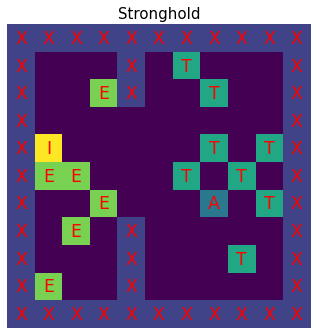

In [6]:
env_size = 11
simplicity = 6
stronghold = Stronghold(env_size, simplicity)
stronghold.reset()
stronghold.render()

In [31]:
def random_policy(): 
    return np.random.randint(0, stronghold.getActionSpace() - 1)

def evaluate_policy(env, policy, episodes = 1000, view = True, print_ep_reward=False):
    # renders the environment and agent at each step if view is True
    # this takes up time so if you want it to be quicker just set view to False
    total_evaluation_reward = 0
    for i in range(episodes):   # iterating over a certain number of episodes 
        env.reset()
        episode_reward = 0
        done = False
        state, reward, done, info = env.step(policy)
        episode_reward += reward
        total_evaluation_reward += reward
        while not done:
            state, reward, done, info = env.step(policy) # perform random step
            episode_reward += reward
            total_evaluation_reward += reward
            if view == True:
                print("state", state)
                env.render()
                time.sleep(0.5)
                clear_output(wait=True)
        if print_ep_reward == True:
            print("Total reward for episode = ", episode_reward)
    return total_evaluation_reward / episodes     # return average reward over all episodes

In [ ]:
env_size = 11
simplicity = 4
stronghold = Stronghold(env_size, simplicity)            
print("Average reward:", evaluate_policy(stronghold, random_policy(), episodes=10, view=False, print_ep_reward=True))

In [19]:
env_size = 11
simplicity = 4
stronghold = Stronghold(env_size, simplicity)            
print("Average reward:", evaluate_policy(stronghold, random_policy(), episodes=10, view=False, print_ep_reward=True)) # <- set view to True if you want the environment to show during evaluation and print to see the reward per episode

Total reward for trial =  927
Total reward for trial =  -1001
Total reward for trial =  -1000
Total reward for trial =  858
Total reward for trial =  970
Total reward for trial =  954
Total reward for trial =  -1019
Total reward for trial =  -1085
Total reward for trial =  -1004
Total reward for trial =  -1021
Average reward: -242.1


In [21]:
env_size = 11
simplicity = 6
stronghold = Stronghold(env_size, simplicity)            
print("Average reward:", evaluate_policy(stronghold, random_policy(), episodes=1000, view=False, print_ep_reward=False)) 

Average reward: -772.561


In [31]:
env_size = 21
simplicity = 6
stronghold = Stronghold(env_size, simplicity)            
print("Average reward:", evaluate_policy(stronghold, random_policy(), episodes=10000, view=False, print_ep_reward=False)) 

Average reward: -1043.9177


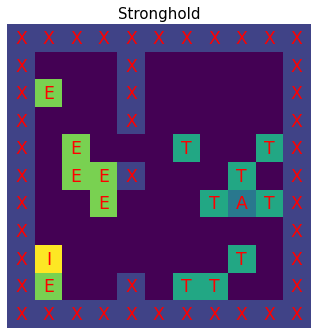

In [ ]:
env_size = 11
simplicity = 6
stronghold = Stronghold(env_size, simplicity)
stronghold.reset()
stronghold.render()

In [ ]:
P = pd.DataFrame(stronghold.P)

In [15]:
P.head()

,0,1,2,3,4,5,6,7,8,9,...,111,112,113,114,115,116,117,118,119,120
0,"[(0.7, 0, -1, False), (0.1, 11, -1, False), (0...","[(0.7, 1, -1, False), (0.1, 12, -1, False), (0...","[(0.7, 2, -1, False), (0.1, 13, -1, False), (0...","[(0.7, 3, -1, False), (0.1, 14, -1, False), (0...","[(0.7, 4, -1, False), (0.1, 15, -1, False), (0...","[(0.7, 5, -1, False), (0.1, 16, -1, False), (0...","[(0.7, 6, -1, False), (0.1, 17, -1, False), (0...","[(0.7, 7, -1, False), (0.1, 18, -1, False), (0...","[(0.7, 8, -1, False), (0.1, 19, -1, False), (0...","[(0.7, 9, -1, False), (0.1, 20, -1, False), (0...",...,"[(0.7, 100, -1000, False), (0.1, 111, -1, Fals...","[(0.7, 101, -1, False), (0.1, 112, -1, False),...","[(0.7, 102, -1, False), (0.1, 113, -1, False),...","[(0.7, 103, -1, False), (0.1, 114, -1, False),...","[(0.7, 104, -1, False), (0.1, 115, -1, False),...","[(0.7, 105, -1000, False), (0.1, 116, -1, Fals...","[(0.7, 106, -1000, False), (0.1, 117, -1, Fals...","[(0.7, 107, -1, False), (0.1, 118, -1, False),...","[(0.7, 108, -1, False), (0.1, 119, -1, False),...","[(0.7, 109, -1, False), (0.1, 120, -1, False),..."
1,"[(0.7, 11, -1, False), (0.1, 0, -1, False), (0...","[(0.7, 12, -1, False), (0.1, 0, -1, False), (0...","[(0.7, 13, -1, False), (0.1, 1, -1, False), (0...","[(0.7, 14, -1, False), (0.1, 2, -1, False), (0...","[(0.7, 15, -1, False), (0.1, 3, -1, False), (0...","[(0.7, 16, -1, False), (0.1, 4, -1, False), (0...","[(0.7, 17, -1, False), (0.1, 5, -1, False), (0...","[(0.7, 18, -1, False), (0.1, 6, -1, False), (0...","[(0.7, 19, -1, False), (0.1, 7, -1, False), (0...","[(0.7, 20, -1, False), (0.1, 8, -1, False), (0...",...,"[(0.7, 111, -1, False), (0.1, 110, -1, False),...","[(0.7, 112, -1, False), (0.1, 111, -1, False),...","[(0.7, 113, -1, False), (0.1, 112, -1, False),...","[(0.7, 114, -1, False), (0.1, 113, -1, False),...","[(0.7, 115, -1, False), (0.1, 114, -1, False),...","[(0.7, 116, -1, False), (0.1, 115, -1, False),...","[(0.7, 117, -1, False), (0.1, 116, -1, False),...","[(0.7, 118, -1, False), (0.1, 117, -1, False),...","[(0.7, 119, -1, False), (0.1, 118, -1, False),...","[(0.7, 120, -1, False), (0.1, 119, -1, False),..."
2,"[(0.7, 0, -1, False), (0.1, 1, -1, False), (0....","[(0.7, 0, -1, False), (0.1, 2, -1, False), (0....","[(0.7, 1, -1, False), (0.1, 3, -1, False), (0....","[(0.7, 2, -1, False), (0.1, 4, -1, False), (0....","[(0.7, 3, -1, False), (0.1, 5, -1, False), (0....","[(0.7, 4, -1, False), (0.1, 6, -1, False), (0....","[(0.7, 5, -1, False), (0.1, 7, -1, False), (0....","[(0.7, 6, -1, False), (0.1, 8, -1, False), (0....","[(0.7, 7, -1, False), (0.1, 9, -1, False), (0....","[(0.7, 8, -1, False), (0.1, 10, -1, False), (0...",...,"[(0.7, 110, -1, False), (0.1, 112, -1, False),...","[(0.7, 111, -1, False), (0.1, 113, -1, False),...","[(0.7, 112, -1, False), (0.1, 114, -1, False),...","[(0.7, 113, -1, False), (0.1, 115, -1, False),...","[(0.7, 114, -1, False), (0.1, 116, -1, False),...","[(0.7, 115, -1, False), (0.1, 117, -1, False),...","[(0.7, 116, -1, False), (0.1, 118, -1, False),...","[(0.7, 117, -1, False), (0.1, 119, -1, False),...","[(0.7, 118, -1, False), (0.1, 120, -1, False),...","[(0.7, 119, -1, False), (0.1, 120, -1, False),..."
3,"[(0.7, 1, -1, False), (0.1, 0, -1, False), (0....","[(0.7, 2, -1, False), (0.1, 1, -1, False), (0....","[(0.7, 3, -1, False), (0.1, 2, -1, False), (0....","[(0.7, 4, -1, False), (0.1, 3, -1, False), (0....","[(0.7, 5, -1, False), (0.1, 4, -1, False), (0....","[(0.7, 6, -1, False), (0.1, 5, -1, False), (0....","[(0.7, 7, -1, False), (0.1, 6, -1, False), (0....","[(0.7, 8, -1, False), (0.1, 7, -1, False), (0....","[(0.7, 9, -1, False), (0.1, 8, -1, False), (0....","[(0.7, 10, -1, False), (0.1, 9, -1, False), (0...",...,"[(0.7, 112, -1, False), (0.1, 100, -1000, Fals...","[(0.7, 113, -1, False), (0.1, 101, -1, False),...","[(0.7, 114, -1, False), (0.1, 102, -1, False),...","[(0.7, 115, -1, False), (0.1, 103, -1, False),...","[(0.7, 116, -1, False), (0.1, 104, -1, False),...","[(0.7, 117

In [13]:
transProb = pd.DataFrame(stronghold.transitionProb[0])

In [14]:
transProb

,0,1,2,3,4,5,6,7,8,9,...,112,113,114,115,116,117,118,119,120,121
0,0.8,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.1,0.7,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.1,0.7,0.1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.1,0.7,0.1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.1,0.7,0.1,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.1,0.1,0.1,0.0,0.0,0.0
118,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.1,0.1,0.1,0.0,0.0
119,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.1,0.1,0.0
120,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.2,0.0


In [16]:
transRew = pd.DataFrame(stronghold.transitionReward)

In [17]:
transRew

,0,1,2,3
0,-1.0,-1.0,-1.0,-1.0
1,-1.0,-1.0,-1.0,-1.0
2,-1.0,-1.0,-1.0,-1.0
3,-1.0,-1.0,-1.0,-1.0
4,-1.0,-1.0,-1.0,-1.0
...,...,...,...,...
117,-1.0,-1.0,-1.0,-1.0
118,-1.0,-1.0,-1.0,-1.0
119,-1.0,-1.0,-1.0,-1.0
120,-1.0,-1.0,-1.0,-1.0
